In [1]:
import pandas as pd
import numpy as np

In [2]:
df=pd.read_csv("../../raw_data/Crimes.csv")

In [3]:
df.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [4]:
df.drop(columns=["X Coordinate", "Y Coordinate", "Latitude", "Longitude", "Location", "Beat"], inplace=True)

## Community area 25


In [5]:
df_4=df.groupby("Community Area").count()
ca_df=df_4[["ID"]].rename(columns={"ID" : "crime_count" })

In [6]:
worst =  float(ca_df[ ca_df["crime_count"]==int(ca_df.max()[0]) ].index[0] )
print(f" The worst community area is Nr. {int(worst)}!")

 The worst community area is Nr. 25!


/var/folders/_y/_w83gnx12c1brw3yy2nbv91m0000gn/T/ipykernel_80360/1255772045.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  worst =  float(ca_df[ ca_df["crime_count"]==int(ca_df.max()[0]) ].index[0] )


In [7]:
df_25=df[df["Community Area"]==worst]

In [8]:
from datetime import datetime

def timer(t):
    return datetime.strptime(t, "%m/%d/%Y %I:%M:%S %p")

In [9]:
df_25["Date_dt"]=df_25["Date"].apply(timer)

/var/folders/_y/_w83gnx12c1brw3yy2nbv91m0000gn/T/ipykernel_80360/3525700377.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_25["Date_dt"]=df_25["Date"].apply(timer)


In [10]:
df_25["Y_M"]=df_25['Date_dt'].dt.to_period('M')

/var/folders/_y/_w83gnx12c1brw3yy2nbv91m0000gn/T/ipykernel_80360/620581492.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_25["Y_M"]=df_25['Date_dt'].dt.to_period('M')


In [11]:
ca25monthly_df=df_25.groupby("Y_M").count().rename(columns={"ID" : "crime_count" })[["crime_count"]]

In [12]:
ca25monthly_df

,crime_count
Y_M,
2001-01,33
2001-02,18
2001-03,16
2001-04,16
2001-05,16
...,...
2024-04,1017
2024-05,1101
2024-06,1225


<Axes: xlabel='Y_M'>

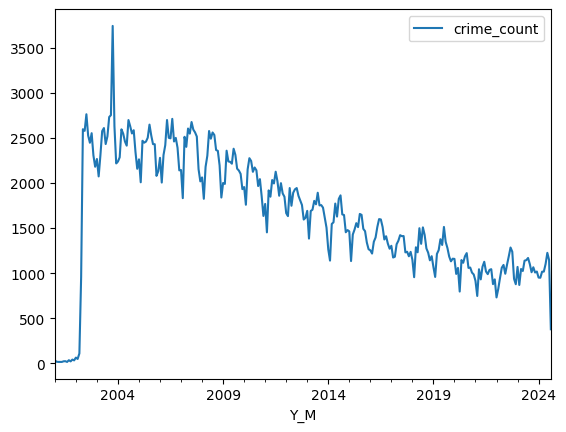

In [13]:
ca25monthly_df.plot()

## RNN model 1

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout

In [116]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [142]:
# DATA PREPROCESS

# turn crimes into list
crime_count_list = list(ca25monthly_df["crime_count"])

# parameters
sequence_length = 12  # number of months to consider for predicting the next months

# create sequences
X, y = [], []
for i in range(sequence_length, len(crime_count_list)):
    X.append(crime_count_list[i-sequence_length:i])
    y.append(crime_count_list[i])

X = np.array(X)
y = np.array(y)

# train_test_split 
train_size = int(len(X) * 0.8)  # 80% for training
X_train_full, X_test, y_train_full, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, shuffle=False)

In [143]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [144]:
X_train_scaled=scaler.transform(X_train)

In [145]:
X_test_scaled=scaler.transform(X_test)
X_val_scaled=scaler.transform(X_val)

In [146]:
from tensorflow.keras.callbacks import EarlyStopping

In [177]:
# 1- RNN Architecture

model = Sequential()

model.add(layers.GRU(units=100, activation='relu', input_shape=(sequence_length,1), return_sequences=True))
#model.add(Dropout(0.1))

model.add(layers.GRU(units=100, activation='relu'))
#model.add(Dropout(0.2))

model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(1, activation="linear"))

# 2- Compilation
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001)) 

# 3- Fit
#es = EarlyStopping(patience=0, restore_best_weights=True)

history=model.fit(X_train_scaled, y_train, epochs=500, verbose=0, batch_size= 16 ,validation_data=(X_val_scaled,y_val)
                  #, callbacks=[es]
                 )

# 4- Predict
y_pred=model.predict(X_test_scaled) 

/Users/user/.pyenv/versions/3.10.6/envs/LW_chicago_crime_pred/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


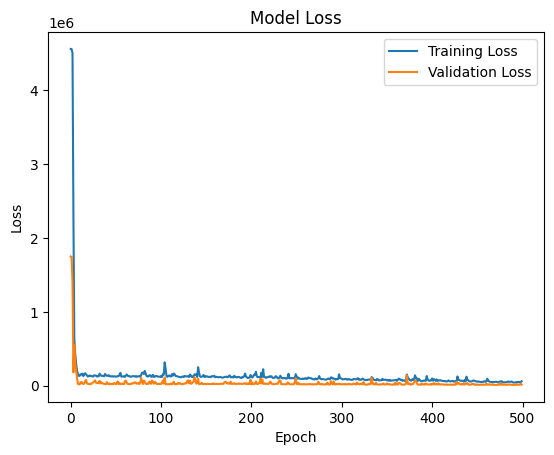

In [178]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [179]:
from sklearn.metrics import r2_score

r2_score(y_test,y_pred)

-0.8485814332962036

# TRY WEEKLY FORECAST

In [181]:
df_25["Y_W"]=df_25['Date_dt'].dt.to_period('W')

/var/folders/_y/_w83gnx12c1brw3yy2nbv91m0000gn/T/ipykernel_80360/1990554854.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_25["Y_W"]=df_25['Date_dt'].dt.to_period('W')


In [184]:
ca25weekly_df=df_25.groupby("Y_W").count().rename(columns={"ID" : "crime_count" })[["crime_count"]]

<Axes: xlabel='Y_W'>

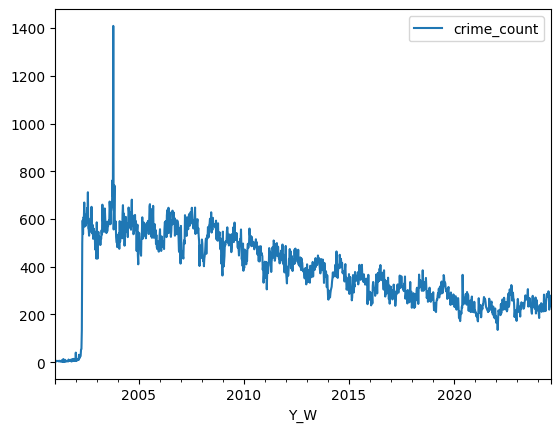

In [186]:
ca25weekly_df.plot();

In [187]:
ca25weekly_df.shape

(1231, 1)

In [257]:
# DATA PREPROCESS

# turn crimes into list
crime_count_list = list(ca25weekly_df["crime_count"])

# parameters
sequence_length = 52  # number of weeks to consider for predicting the next week

# create sequences
X, y = [], []
for i in range(sequence_length, len(crime_count_list)):
    X.append(crime_count_list[i-sequence_length:i])
    y.append(crime_count_list[i])

X = np.array(X)
y = np.array(y)

# train_test_split 
train_size = int(len(X) * 0.8)  # 80% for training
X_train_full, X_test, y_train_full, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, shuffle=False)

In [258]:
scaler.fit(X_train)

StandardScaler()

In [259]:
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)
X_val_scaled=scaler.transform(X_val)

In [280]:
# 2nd RNN Architecture

model = Sequential()

model.add(layers.GRU(units=128, activation='relu', input_shape=(sequence_length,1)
                     , return_sequences=True
                    ) )
#model.add(Dropout(0.1))

model.add(layers.GRU(units=64, activation='relu'
                     #, return_sequences=True
                    ))
#model.add(Dropout(0.2))

#model.add(layers.Dense(20, activation="relu"))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(1, activation="linear"))

# 2- Compilation
model.compile(loss='mae', 
              optimizer=Adam(learning_rate=0.001)) 

# 3- Fit
#es = EarlyStopping(patience=0, restore_best_weights=True)

history=model.fit(X_train_scaled, y_train, epochs=200, verbose=1, batch_size= 16 ,validation_data=(X_val_scaled,y_val)
                  #, callbacks=[es]
                 )

# 4- Predict
y_pred=model.predict(X_test_scaled) 

Epoch 1/200


/Users/user/.pyenv/versions/3.10.6/envs/LW_chicago_crime_pred/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1888.8339 - val_loss: 278.2226
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 3973.2156 - val_loss: 295.1689
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1650.8466 - val_loss: 297.7048
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 29657.0645 - val_loss: 302.7013
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2329.3047 - val_loss: 291.8883
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2695.2832 - val_loss: 298.8298
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 641.2719 - val_loss: 296.8629
Epoch 8/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 873.6224 - val_loss: 298.3684
Epoch 9/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 599.0573 - val_loss: 298.0560
Epoch 10/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 762.8553 - val_loss: 296.0253
Epoch 11/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 986.0609 - val_loss: 297.7329
Epoch 12/200


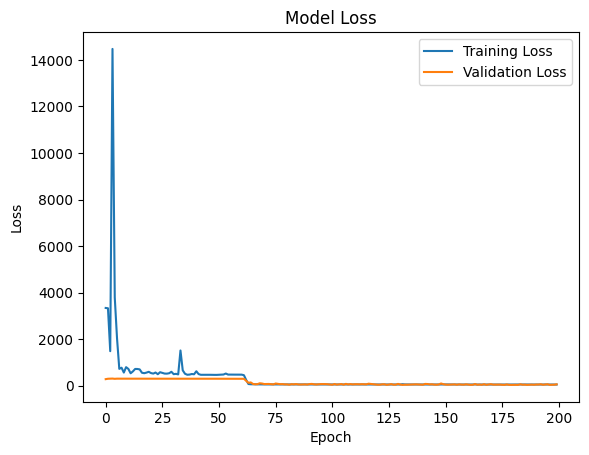

In [281]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [282]:
history.history

{'loss': [3338.0126953125,
  3325.619140625,
  1480.4522705078125,
  14472.9013671875,
  3788.927490234375,
  2031.0421142578125,
  720.8092651367188,
  769.764404296875,
  560.8413696289062,
  794.05712890625,
  718.3468017578125,
  530.3259887695312,
  611.105712890625,
  716.3440551757812,
  715.1180419921875,
  697.6981811523438,
  552.7390747070312,
  534.291259765625,
  559.3909301757812,
  593.5667114257812,
  538.8627319335938,
  517.2086791992188,
  563.051513671875,
  490.5175476074219,
  576.3499755859375,
  547.1220703125,
  518.072021484375,
  514.905517578125,
  531.8787231445312,
  594.45556640625,
  492.8836669921875,
  505.6906433105469,
  482.6689758300781,
  1510.4395751953125,
  657.1316528320312,
  509.4757385253906,
  467.04852294921875,
  474.5328063964844,
  499.0908203125,
  488.0182189941406,
  617.7606811523438,
  495.7948303222656,
  465.08648681640625,
  465.7333679199219,
  464.1257019042969,
  466.8404235839844,
  465.3532409667969,
  462.11474609375,
  4

In [283]:
abs(y_test-y_pred)[0].mean()

135.34381206965043

In [284]:
r2_score(y_test,y_pred)

-22.168060302734375